## Lecture 4

#### Goals
* Know how and why to construct a Gaussian Pyramid
* Know how and why to construct a Laplacian Pyramid
* Be prepared to complete Project 1

---
(as time allows)
* Understand the high-level steps in a panorama stitching system
* Understand the motivation and high-level steps in image matching: feature detection, description, and matching
* Be able to describe examples of *global* and *local* image features.


(if we have time?)
Introduce our running long-term goal of building a panorama stitching system
* Overview
* Feature detection and matching

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering

#### Edge Detection: Revisited


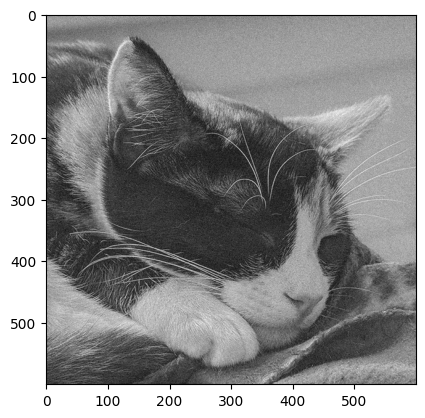

In [2]:
beans = imageio.imread("../data/beans.jpg")
beans_small = skim.transform.rescale(beans, 0.25, anti_aliasing=True) # smaller beans
bg = skim.color.rgb2gray(beans) # grayscale beans

bn = bg + np.random.randn(*bg.shape) * 0.05 # grayscale noisy beans
plt.imshow(bn, cmap="gray")

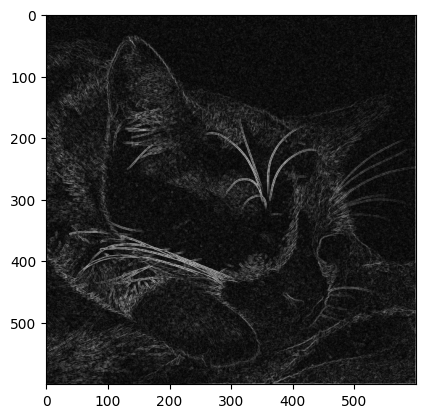

In [3]:
# take a look at filtering.grad_mag
beans_gradient = filtering.grad_mag(bn)
util.imshow_gray(beans_gradient)

If we fed this into Canny or somesuch, would it give us "good" edges? 

Try zooming in a bit on the edges of her head. You'd think those would be important edges... 

How strong is the gradient magnitude there?

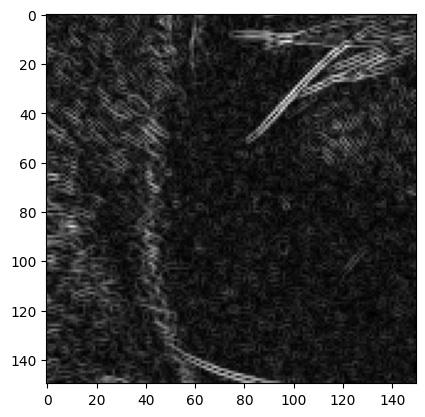

In [4]:
util.imshow_gray(beans_gradient[200:350, 50:200])

Issue: what we conceptualize as edges exist at different spatial scales (or *frequencies*!)

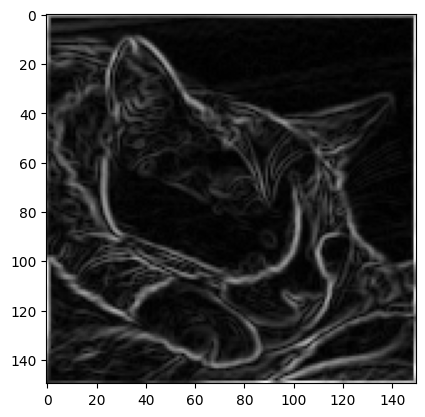

In [9]:
bn_small = filtering.down_4x(bn)
util.imshow_gray(filtering.grad_mag(bn_small))

In [ ]:
util.imshow_gray(cv2.Canny((beans_small * 255).astype(np.uint8), 150, 230))

So you want to take a derivative at a different scale... how should we go about it?
* 
* 

##### Homework Problem 1
Suppose you want to detect edges at a 2x reduced spatial scale. You have two choices: double the size of your gradient filters, or halve the size of your image (in both height and width). Calculate and compare the number of multiplications required per input pixel to perform just the filtering steps in each of these approaches. Assume that your downsampling prefilter is 5x5 and a "double size" sobel filter would end up being 7x7. Which approach will be more efficient if you want to detect edges at multiple reduced spatial scales?

For now: which of these do you *think* will be more efficient?

### Gaussian Pyramid

Idea: recursively downsample (recall: blur-then-subsample!) to create a multi-scale **image pyramid**.

In [10]:
G = [bg]
levels = 6
for i in range(levels):
    G.append(filtering.down_2x(G[-1]))
print(len(G))

7


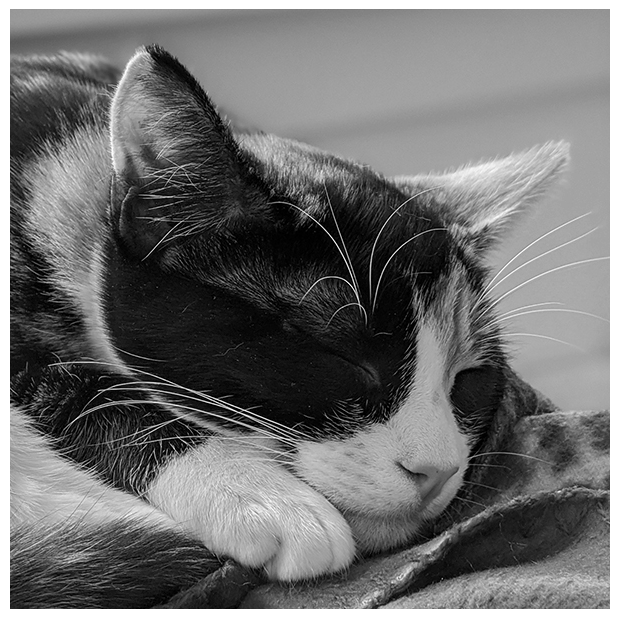

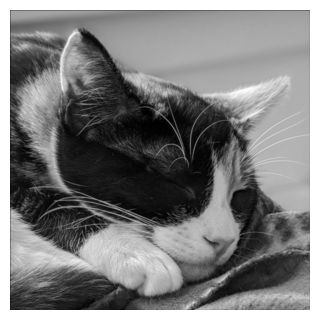

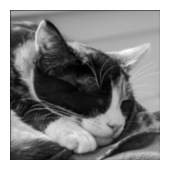

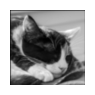

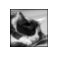

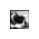

In [12]:

# fig, axs = plt.subplots(1, len(G))
for i, lvl in enumerate(G):
    util.imshow_truesize(lvl)

#### Frequency Content in the Gaussian Pyramid

Each level contains a subset of the original image's frequencies, with the cutoff getting lower at each level.

Frequencyometer illustration:

In [ ]:
for i, lvl in enumerate(G):
    fig = plt.figure(figsize=(3, 5))
    fig.gca().set_axis_off()
    util.imshow_gray(lvl)

##### Homework Problem 2

Suppose you have a 128x128 image, and you compute a full Gaussian pyramid (i.e., every possible level down to a 1x1 image). What multiple of the original image storage is required to store the entire pyramid?

### Laplacian Pyramids

Thinking back to sharpening: what is **lost** from one level of the pyramid to the next?

$G_{i+1} = \textrm{subsample}(\textrm{blur}(G_i))$

Each level of a **Laplacian** pyramid captures this:

$$
\begin{align*}
L_i &= G_i - \textrm{blur}(G_i) \textrm{ if } i < k\\
L_k &= G_k
\end{align*}
$$

where $k$ is index of the highest level (number of levels minus one, since we've zero-indexed).

**Ponder**: why should we have the special case for the last (highest, lowest-resolution) level?

In [21]:
from filtering_future import construct_laplacian # you'll write this yourself in P1!
L = construct_laplacian(filtering.down_2x(bg), 3)

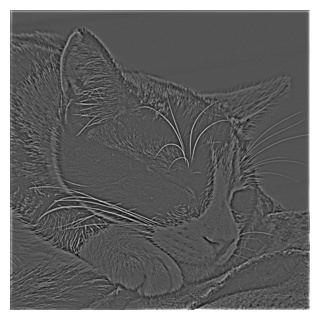

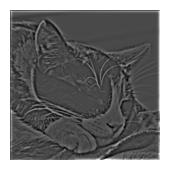

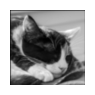

In [22]:
# fig, axs = plt.subplots(1, len(G))
for i, lvl in enumerate(L):
    util.imshow_truesize(lvl)

#### Frequency Content in the Laplacian Pyramid


In [ ]:
for i, lvl in enumerate(L):
    fig = plt.figure(figsize=(3, 5))
    fig.gca().set_axis_off()
    util.imshow_gray(lvl)

##### Homework Problems 3-5

Suppose you are given the Laplacian and Gaussian pyramids for an input image $I.$ $G_{0 \ldots k}$ are the Gaussian pyramid levels starting at the original image ($G_0$), while the Laplacian layers $L_{0\ldots k}$ are the "detail" layers, with each $L_i$  at the same resolution as $G_i$.

(3) When is it the case that $G_\ell = L_\ell$?

(4) Given all levels of both pyramids, give an expression that yields a result as close as possible to $G_j$ with a **sharpening** filter applied. You don't need to actually do any filtering.

(5) Give an algorithm to reconstruct $G_0$ using **only** the levels of $L$.

## Project 1 Demo

`python hybrid_gui.py -t resources/sample-correspondence.json -c resources/sample-config.json`

`python laplacian_gui.py --image resources/beans.jpg --levels 4`

`python local_laplacian_gui.py --image resources/flower-square.png`

#### Tips on numpy efficiency

* Loops are slow. Get rid of them wherever possible!
    * Example: remove 2 for loops from filtering.filter
    * Full efficiency points on P1 requires removing all loops over the image pixels!
* General advice: batch as many operations that are happening anyway into a single operation.
* There is usually a numpy function to do that thing you're trying to do.

## Moving on to the next thing...

We're going to switch gears a little and introduce a long-term motivating application that will end up being Project 2: 

# Panorama Stitching

The high-level steps for panorama stitching are as follows - see the slides for more detail and visuals.

1. Figure out the geometric relationship between images
2. Align images to each other
3. Blend them together

Starting with step 1, we have a few sub-steps:
1. Figure out the geometric relationship between images
   
   (a) Identify matching points in neighboring images
   
   (b) Model (and estimate) the geometric mapping from one point set to another

Step 1 (a) itself has some sub-steps:
1. (a) Identify matching points in neighboring images
    * Find points that would be good to match
    * Extract a "descriptor" that captures local image information
    * Find matching pairs of features using their descriptors.

... and this brings us to our starting point for next class: **what features should we try to match**?